In [ ]:
#### inceptionv3 https://www.machinelearningnuggets.com/transfer-learning-guide/

#### inceptionv3 https://www.machinelearningnuggets.com/transfer-learning-guide/

In [ ]:
import tensorflow as tf
import numpy as np
import os
import glob
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tabulate import tabulate

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def get_history_stats(history):
    print(f"Accuracy: {max(history['accuracy']):.{4}f}")
    print(f"Validation accuracy: {max(history['val_accuracy']):.{4}f}")
    print(f"Loss: {min(history['loss']):.{4}f}")
    print(f"Validation loss : {min(history['val_loss']):.{4}f}")   

In [ ]:
def plot_hist(history):
    plt.figure(figsize=(7, 7))
    plt.subplot(2, 1, 1)
    plt.plot(history["accuracy"], label='Training Accuracy')
    plt.plot(history["val_accuracy"], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([0.5,1])
    plt.title('Training and Validation Accuracy')
    
    plt.subplot(2, 1, 2)
    plt.plot(history["loss"], label='Training Loss')
    plt.plot(history["val_loss"], label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [ ]:
def plot_total_hist(history1, history2, fine_tunning_epoch):
    initial_epochs = fine_tunning_epoch
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(history1["accuracy"] + history2["accuracy"], label='Training Accuracy')
    plt.plot(history1["val_accuracy"] + history2["val_accuracy"], label='Validation Accuracy')
    plt.ylim([0.5, 1])
    plt.plot([initial_epochs-1,initial_epochs-1],
    plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(history1["loss"] + history2["loss"], label='Training Loss')
    plt.plot(history1["val_loss"] + history2["val_loss"], label='Validation Loss')
    plt.ylim([0, 1.0])
    plt.plot([initial_epochs-1,initial_epochs-1],
    plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [ ]:

def model_info(model, verbose=0):
    layer_info = []
    header = ["Number", "Name", "Input_shape", "Output_shape", "Trainable"]
    data = [[]]
    trainable_layers, non_trainable_layers = 0, 0
    trainable_params, non_trainable_params = 0, 0
    for i, layer in enumerate(model.layers):
        layer_name = layer.name
        input_shape = layer.input_shape[1:]
        output_shape = layer.output_shape[1:]
        trainable = layer.trainable
        layer_type = type(layer).__name__
        data.append([i, layer_type if layer_type != "Functional" else layer.name, input_shape, output_shape, trainable])
        layer_params = np.sum([np.prod(p.shape) for p in layer.weights])
        if trainable:
            trainable_params += layer_params
            trainable_layers += 1
        else:
            non_trainable_params += layer_params
            non_trainable_layers += 1
    print("=========================================================")
    print(f"Total params: {int(trainable_params + non_trainable_params):,}")
    print(f"Trainable params: {int(trainable_params):,}")
    print(f"Non-trainable params: {int(non_trainable_params):,}")
    print(f"Total layers: {len(model.layers):,}")
    print(f"Trainable layers: {trainable_layers:,}")
    print(f"Non-trainable params: {non_trainable_layers:,}")
    print("=========================================================")
    if verbose == 1:
        print(tabulate(data, headers=header, colalign="c", tablefmt="github"))

In [ ]:
os.listdir("/content/drive/MyDrive/Datasets/data")

['val', 'train']

In [ ]:
PATH = "/content/drive/MyDrive/Datasets/data"
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'val')
BATCH_SIZE = 32
IMG_SIZE = (150, 150)
IMG_SHAPE = IMG_SIZE + (3,)

####  cargando datos

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 2637 files belonging to 2 classes.
Found 660 files belonging to 2 classes.


#### model checkpoints

In [ ]:
# checkpoints

callbacks_path = "/content/drive/MyDrive/Colab Notebooks/Notebooks_importatntes/inception_models/"

model_name = callbacks_path + "best_model.h5"
fine_model_name = callbacks_path + "best_model_fine.h5"

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=model_name, 
                                                      monitor="val_accuracy", 
                                                      save_best_only=True, 
                                                      save_weights_only=False, 
                                                      verbose=1,
                                                      mode="max")

fine_model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=fine_model_name, 
                                                      monitor="val_accuracy", 
                                                      save_best_only=True, 
                                                      save_weights_only=False, 
                                                      verbose=1,
                                                      mode="max")

#### creacion del modelo

In [ ]:
base_model = tf.keras.applications.inception_v3.InceptionV3(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=IMG_SHAPE,
    include_top=False,  #Exclude ImageNet classifier at the top
)

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [ ]:
model_info(base_model, verbose=1)

Total params: 21,802,784
Trainable params: 21,802,784
Non-trainable params: 0
Total layers: 311
Trainable layers: 311
Non-trainable params: 0
|   Number | Name               | Input_shape                                                  | Output_shape   | Trainable   |
|----------|--------------------|--------------------------------------------------------------|----------------|-------------|
|          |                    |                                                              |                |             |
| 0        | InputLayer         | []                                                           | []             | True        |
| 1        | Conv2D             | (150, 150, 3)                                                | (74, 74, 32)   | True        |
| 2        | BatchNormalization | (74, 74, 32)                                                 | (74, 74, 32)   | True        |
| 3        | Activation         | (74, 74, 32)                                            

In [ ]:
base_model.trainable = False

In [ ]:
model_info(base_model)

Total params: 21,802,784
Trainable params: 0
Non-trainable params: 21,802,784
Total layers: 311
Trainable layers: 0
Non-trainable params: 311


In [ ]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"), #flips images 
    tf.keras.layers.RandomRotation(0.1),#randomly rotates images
    #tf.keras.layers.RandomZoom(.5, .2), #randomly zooms images 
])

preprocess_input = tf.keras.applications.inception_v3.preprocess_input

In [ ]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)  # Apply random data augmentation
x = preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
#scale_layer = tf.keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
#x = scale_layer(x)

In [ ]:
learning_rate = 5e-4

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics='accuracy')


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 150, 150, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 150, 150, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0     

In [ ]:
model_info(model, verbose=1)

Total params: 23,901,985
Trainable params: 2,099,201
Non-trainable params: 21,802,784
Total layers: 9
Trainable layers: 8
Non-trainable params: 1
|   Number | Name                   | Input_shape   | Output_shape   | Trainable   |
|----------|------------------------|---------------|----------------|-------------|
|          |                        |               |                |             |
| 0        | InputLayer             | []            | []             | True        |
| 1        | Sequential             | (150, 150, 3) | (150, 150, 3)  | True        |
| 2        | TFOpLambda             | (150, 150, 3) | (150, 150, 3)  | True        |
| 3        | TFOpLambda             | (150, 150, 3) | (150, 150, 3)  | True        |
| 4        | inception_v3           | (150, 150, 3) | (3, 3, 2048)   | False       |
| 5        | GlobalAveragePooling2D | (3, 3, 2048)  | (2048,)        | True        |
| 6        | Dense                  | (2048,)       | (1024,)        | True        |
| 7 

In [ ]:
initial_epochs = 20

In [ ]:
history = model.fit(train_dataset,
                 epochs=initial_epochs, 
                 validation_data = validation_dataset,
                 callbacks=[model_checkpoint])

Epoch 1/20


/usr/local/lib/python3.9/dist-packages/keras/backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


83/83 [==============================] - ETA: 0s - loss: 0.6005 - accuracy: 0.7425
Epoch 1: val_accuracy improved from -inf to 0.78788, saving model to /content/drive/MyDrive/Colab Notebooks/Notebooks_importatntes/inception_models/best_model.h5
83/83 [==============================] - 367s 4s/step - loss: 0.6005 - accuracy: 0.7425 - val_loss: 0.4774 - val_accuracy: 0.7879
Epoch 2/20
83/83 [==============================] - ETA: 0s - loss: 0.4599 - accuracy: 0.7990
Epoch 2: val_accuracy did not improve from 0.78788
83/83 [==============================] - 196s 2s/step - loss: 0.4599 - accuracy: 0.7990 - val_loss: 0.5208 - val_accuracy: 0.7818
Epoch 3/20
83/83 [==============================] - ETA: 0s - loss: 0.4293 - accuracy: 0.8093
Epoch 3: val_accuracy improved from 0.78788 to 0.80152, saving model to /content/drive/MyDrive/Colab Notebooks/Notebooks_importatntes/inception_models/best_model.h5
83/83 [==============================] - 196s 2s/step - loss: 0.4293 - accuracy: 0.8093 - v

In [ ]:
print(history.history)

{'loss': [0.6004762053489685, 0.45985621213912964, 0.42926254868507385, 0.4252150058746338, 0.3909206688404083, 0.3803669214248657, 0.37212568521499634, 0.3486502766609192, 0.35280510783195496, 0.33969613909721375, 0.3298179805278778, 0.32492703199386597, 0.3061787188053131, 0.29189202189445496, 0.3144164979457855, 0.2922065854072571, 0.28793108463287354, 0.2855098843574524, 0.26816481351852417, 0.2762511372566223], 'accuracy': [0.7425104379653931, 0.7990140318870544, 0.809252917766571, 0.8058399558067322, 0.8308684229850769, 0.8263177871704102, 0.829351544380188, 0.8411073088645935, 0.8388320207595825, 0.8475540280342102, 0.8467956185340881, 0.8532423377037048, 0.8634812235832214, 0.872961699962616, 0.8577929735183716, 0.8672733902931213, 0.8820629715919495, 0.873720109462738, 0.8835798501968384, 0.8782707452774048], 'val_loss': [0.4774128198623657, 0.5207982063293457, 0.4423634707927704, 0.5026200413703918, 0.40301188826560974, 0.5917202234268188, 0.3844418227672577, 0.37576088309288

In [ ]:
base_model.trainable = True

In [ ]:
fine_layer_unfrize = 25

In [ ]:
for i, layer in enumerate(base_model.layers[:-fine_layer_unfrize]):
    layer.trainable = False
for i, layer in enumerate(base_model.layers[-fine_layer_unfrize:]):
        if isinstance(layer, tf.keras.layers.BatchNormalization) or isinstance(layer, tf.keras.layers.AveragePooling2D):
            layer.trainable = False

In [ ]:
model_info(base_model, verbose=1)

Total params: 21,802,784
Trainable params: 2,818,048
Non-trainable params: 18,984,736
Total layers: 311
Trainable layers: 17
Non-trainable params: 294
|   Number | Name               | Input_shape                                                  | Output_shape   | Trainable   |
|----------|--------------------|--------------------------------------------------------------|----------------|-------------|
|          |                    |                                                              |                |             |
| 0        | InputLayer         | []                                                           | []             | False       |
| 1        | Conv2D             | (150, 150, 3)                                                | (74, 74, 32)   | False       |
| 2        | BatchNormalization | (74, 74, 32)                                                 | (74, 74, 32)   | False       |
| 3        | Activation         | (74, 74, 32)                                   

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate/10),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 150, 150, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 150, 150, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0     

In [ ]:
fine_epochs = 20
fine_history = model.fit(train_dataset,
                        validation_data = validation_dataset,
                        epochs=initial_epochs + fine_epochs,
                        initial_epoch=history.epoch[-1], 
                        verbose = 1,
                        callbacks=[fine_model_checkpoint])

Epoch 20/40
83/83 [==============================] - ETA: 0s - loss: 0.2698 - accuracy: 0.8855
Epoch 20: val_accuracy improved from -inf to 0.82879, saving model to /content/drive/MyDrive/Colab Notebooks/Notebooks_importatntes/inception_models/best_model_fine.h5
83/83 [==============================] - 208s 2s/step - loss: 0.2698 - accuracy: 0.8855 - val_loss: 0.3985 - val_accuracy: 0.8288
Epoch 21/40
83/83 [==============================] - ETA: 0s - loss: 0.2305 - accuracy: 0.9029
Epoch 21: val_accuracy did not improve from 0.82879
83/83 [==============================] - 191s 2s/step - loss: 0.2305 - accuracy: 0.9029 - val_loss: 0.4340 - val_accuracy: 0.8182
Epoch 22/40
83/83 [==============================] - ETA: 0s - loss: 0.2144 - accuracy: 0.9067
Epoch 22: val_accuracy improved from 0.82879 to 0.84848, saving model to /content/drive/MyDrive/Colab Notebooks/Notebooks_importatntes/inception_models/best_model_fine.h5
83/83 [==============================] - 187s 2s/step - loss: 0.

In [ ]:
print(fine_history.history)

{'loss': [0.2697564959526062, 0.23046401143074036, 0.2144227772951126, 0.21005235612392426, 0.19426976144313812, 0.17966939508914948, 0.19841182231903076, 0.17836271226406097, 0.16518208384513855, 0.1568632870912552, 0.14969024062156677, 0.15087692439556122, 0.15130296349525452, 0.1438218206167221, 0.14618249237537384, 0.13082318007946014, 0.12988536059856415, 0.12841227650642395, 0.10801837593317032, 0.1143500804901123, 0.12004992365837097], 'accuracy': [0.8854759335517883, 0.9029200077056885, 0.9067121744155884, 0.912779688835144, 0.9196056127548218, 0.9264315366744995, 0.9120212197303772, 0.9268107414245605, 0.9302237629890442, 0.9343951344490051, 0.9400834441184998, 0.9400834441184998, 0.9400834441184998, 0.9423587322235107, 0.9389457702636719, 0.9529768824577332, 0.9465301632881165, 0.9480470418930054, 0.958285927772522, 0.9575275182723999, 0.958285927772522], 'val_loss': [0.39845970273017883, 0.4340168833732605, 0.39753538370132446, 0.4090709388256073, 0.3862978518009186, 0.39108

In [ ]:
get_history_stats(history.history)

Accuracy: 0.8836
Validation accuracy: 0.8439
Loss: 0.2682
Validation loss : 0.3758


In [ ]:
get_history_stats(fine_history.history)

Accuracy: 0.9583
Validation accuracy: 0.8606
Loss: 0.1080
Validation loss : 0.3769


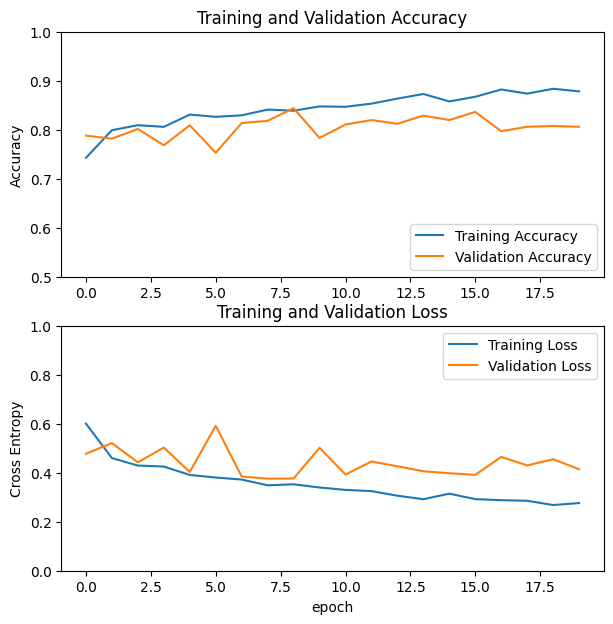

In [ ]:
plot_hist(history.history)

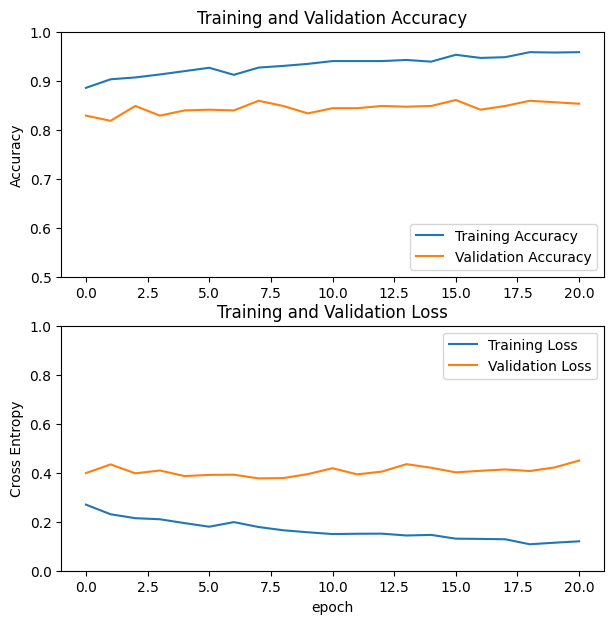

In [ ]:
plot_hist(fine_history.history)

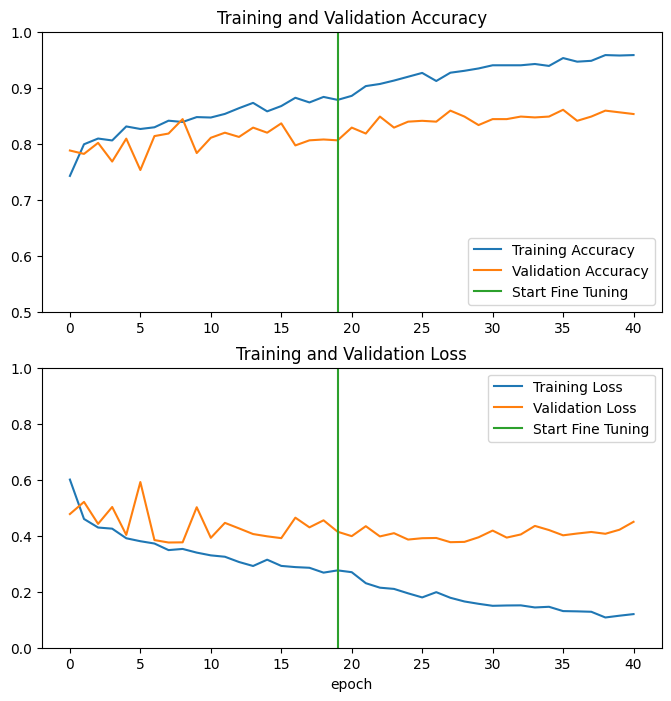

In [ ]:
plot_total_hist(history.history, fine_history.history, fine_epochs)